In [1]:
import torchtext
import pandas as pd
import numpy as np
import sklearn.metrics
from collections import defaultdict
from tqdm import tqdm

In [2]:
df=pd.read_csv('./parallelograms-revisited/experiment1_data_completions/experiment1a_counts.csv')

In [3]:
df=df.drop(columns=['prompt'])

In [54]:
vocab = torchtext.vocab.GloVe(name='42B', dim=300)

.vector_cache/glove.42B.300d.zip: 1.88GB [15:00, 2.08MB/s]                               
100%|█████████▉| 1917493/1917494 [02:46<00:00, 11528.54it/s]


In [10]:
def get_ranks(df, cd_ranks, p_ranks):
    for idx, row in tqdm(df.iterrows()):
    # for idx, row in df.iterrows():
        w1, w2, w3 = row['prompt_w1'], row['prompt_w2'], row['prompt_w3']
        # print(w1, w2, w3)

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi:
            print(w1, w2, w3)
            continue
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        
        row.pop('prompt_w1')
        row.pop('prompt_w2')
        row.pop('prompt_w3')
        
        # print('popped')

        cd_sim = sklearn.metrics.pairwise.cosine_similarity(c.reshape(1, -1), vocab.vectors)
        cd_sorted_indices = (-cd_sim).argsort()[0]
        cd_stoi = dict(zip(vocab.itos, cd_sorted_indices))

        d = b - a + c 
        p_sim = sklearn.metrics.pairwise.cosine_similarity(d.reshape(1, -1), vocab.vectors)
        p_sorted_indices = (-p_sim).argsort()[0]
        p_stoi = dict(zip(vocab.itos, p_sorted_indices))
        
        # print('constructed stoi')
        
        for key, value in row.items():
            if key not in cd_stoi:
                continue
            cd_idx = cd_stoi[key]
            cd_ranks[cd_idx] += value

            p_idx = p_stoi[key]
            p_ranks[p_idx] += value

In [11]:
cd_ranks = np.zeros(len(vocab.itos))
p_ranks = np.zeros(len(vocab.itos))
get_ranks(df, cd_ranks, p_ranks)

25it [04:06,  9.87s/it]

lamb chop lamb chapter


31it [04:56,  9.51s/it]

launchpad helicopter diving board


34it [05:15,  8.65s/it]

basketball hoop soccer ball


36it [05:25,  7.54s/it]

law school lawyer medical school


43it [06:24,  9.34s/it]

basket picnic lunch box


45it [06:34,  8.03s/it]

furnace coal wood stove


61it [09:03,  9.88s/it]

movie screen game show


65it [09:33,  9.18s/it]

lamb chop lamb pork chop


71it [10:22,  9.42s/it]

flock goose wolf pack


78it [11:22,  9.66s/it]

law school lawyer vineyard


80it [11:32,  8.66s/it]


In [12]:
cd_cumsum = np.cumsum(cd_ranks)
p_cumsum = np.cumsum(p_ranks)

In [13]:
cd_cumsum, p_cumsum

(array([   0.,    0.,    0., ..., 2089., 2089., 2089.]),
 array([   0.,    0.,    0., ..., 2089., 2089., 2089.]))

In [18]:
pcts = np.arange(len(cd_cumsum)) / len(cd_cumsum) * 100

In [15]:
cd_cumsum_pct = cd_cumsum / cd_cumsum[-1]
p_cumsum_pct = p_cumsum / p_cumsum[-1]


In [16]:
import matplotlib.pyplot as plt

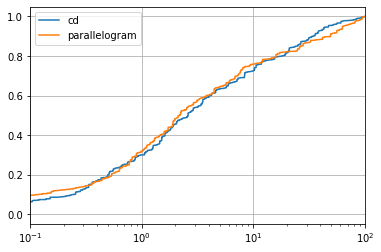

In [22]:
fig, ax = plt.subplots()
ax.plot(pcts, cd_cumsum_pct, label='cd')
ax.plot(pcts, p_cumsum_pct, label='parallelogram')

ax.set_xscale('log')
ax.set_xlim((1e-1, 1e2))
ax.legend()
ax.grid()

In [25]:
queen = vocab['woman'] - vocab['man'] + vocab['king']
cd_sim = sklearn.metrics.pairwise.cosine_similarity(queen.reshape(1, -1), vocab.vectors)
cd_sorted_indices = (-cd_sim).argsort()[0]
cd_stoi = dict(zip(vocab.itos, cd_sorted_indices))

In [26]:
cd_stoi['queen']

90950

In [35]:
queen.shape

torch.Size([300])

In [38]:
vocab['king'].shape

torch.Size([300])

In [48]:
queen = vocab['woman']  + vocab['king'] - vocab['man']

In [50]:
sklearn.metrics.pairwise.cosine_similarity(queen.reshape(1, -1), queen.reshape(1, -1))

array([[1.]], dtype=float32)

In [52]:
sklearn.metrics.pairwise.cosine_similarity(queen.reshape(1, -1), vocab['queen'].reshape(1, -1))

array([[0.78808445]], dtype=float32)

In [53]:
sklearn.metrics.pairwise.cosine_similarity(queen.reshape(1, -1), vocab['king'].reshape(1, -1))

array([[0.80242586]], dtype=float32)